In [1]:
import os
import json
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from p_tqdm import p_map
from tqdm.notebook import tqdm

cwd = os.getcwd()
cwd

'c:\\Users\\hhl08\\Desktop\\CL-crowd-training'

## Ability & Difficulty Distribution

### Col Names:

In [2]:
col_names = ['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country']

### DFs for different classes

In [3]:
diff_dfs = {}
ability_dfs = {}

for cur_col in col_names:
    fitted_param_path = os.path.join(cwd, 'train_only_data', 'fitted_IRT', cur_col, 'best_parameters.json')
    best_param_json = json.load(open(fitted_param_path))
    ids = [best_param_json['item_ids'][i] for i in best_param_json['item_ids']]

    # difficulties df
    diff_df = pd.DataFrame({'ID': ids, 'diff': best_param_json['diff']})
    task_df = pd.read_csv(os.path.join(cwd, 'train_only_data', 'task', cur_col + '.csv'))
    diff_df = pd.merge(task_df, diff_df, on='ID')
    ability_df = pd.DataFrame(best_param_json['ability'])

    # append
    diff_dfs[cur_col] = diff_df
    ability_dfs[cur_col] = ability_df

In [4]:
# check
print(ability_dfs.keys())
print(diff_dfs.keys())

dict_keys(['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country'])
dict_keys(['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country'])


In [5]:
ability_dfs['Study Period']

,0
0,1.450007
1,1.287320
2,1.471874
3,1.378249
4,1.506543
...,...
103,1.440963
104,2.081222
105,2.219762
106,1.605534


In [6]:
diff_dfs['Country']

,ID,Pos_support_locs,Neg_support_locs,Query_loc,Label,Alpha,Aug_type,diff
0,00023041-4878-4156-9285-be9283756080,"[50, 83, 37, 75, 36]","[263, 562, 428, 504, 476]",618,0.0,4,3,-1.853377
1,0003a379-00df-40b9-a2ea-48c2be8a69a3,"[7, 71, 37, 41, 43]","[189, 402, 590, 145, 161]",99,1.0,4,2,2.066802
2,00040fc6-723a-487b-92f7-7c86be7fbb18,"[135, 64, 104, 115, 7]","[190, 569, 168, 159, 613]",137,1.0,5,1,-0.148846
3,000446a8-ac61-40ed-b1ee-834e3de1a31a,"[43, 134, 71, 50, 131]","[600, 120, 520, 193, 381]",33,1.0,1,4,3.463344
4,0005769e-cb8c-4ef5-9130-e1dcc01224c7,"[41, 43, 115, 71, 75]","[199, 400, 484, 159, 633]",101,1.0,0,4,-2.717389
...,...,...,...,...,...,...,...,...
34991,fff2f158-6e7e-4b04-a18c-0d10b417ed92,"[100, 43, 50, 133, 136]","[183, 19, 24, 424, 314]",137,1.0,0,1,-2.389452
34992,fff4175d-dd52-4a22-8498-58d44625a3a5,"[63, 83, 106, 135, 36]","[161, 345, 577, 88, 480]",104,1.0,5,3,-0.083299
34993,fff4908f-fdcb-420f-a896-94277cafbcca,"[33, 104, 133, 75, 41]","[284, 597, 348, 167, 368]",36,1.0,5,1,1.676750
34994,fff70857-2dca-417a-a285-10a6ca31b216,"[111, 43, 136, 83, 63]","[186, 244, 598, 176, 284]",445,0.0,1,3,2.475488


### Plots

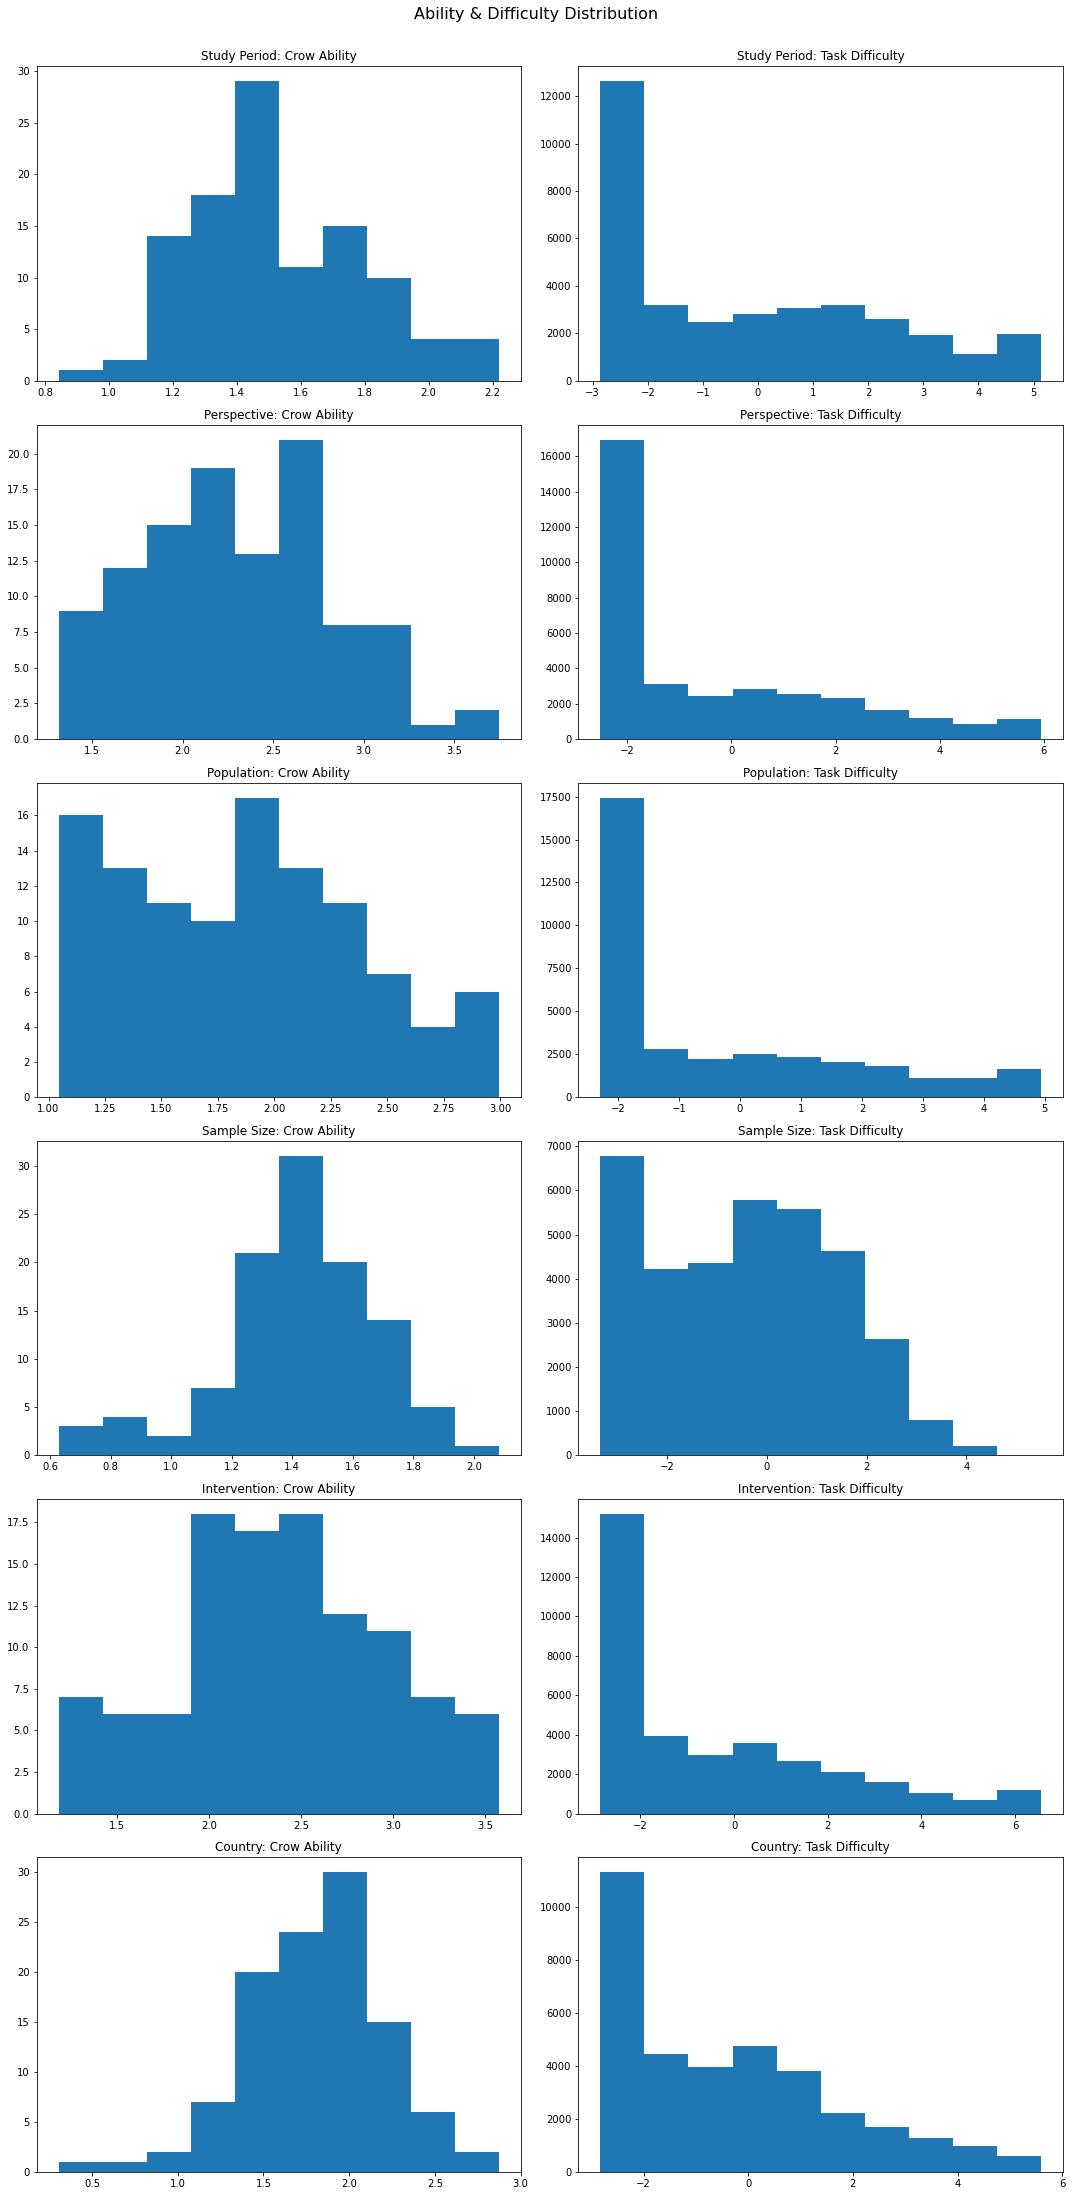

In [7]:
# overall
fig, axes = plt.subplots(len(col_names), 2, figsize=(15,30))
for i, cur_col in enumerate(col_names):
    axes[i][0].hist(ability_dfs[cur_col].iloc[:, 0])
    axes[i][0].title.set_text(f'{cur_col}: Crow Ability')
    axes[i][1].hist(diff_dfs[cur_col]['diff'])
    axes[i][1].title.set_text(f'{cur_col}: Task Difficulty')
fig.tight_layout()
fig.suptitle('Ability & Difficulty Distribution', size=16, y=1.015)
fig.savefig(os.path.join(cwd, 'saved_figures', 'overall_ability_difficulty.png'), bbox_inches='tight')
plt.show()

### Col Names

In [8]:
col_names = ['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country']

### Estimate Task Accuracy

In [ ]:
# function
def one_task_acc(the_task_id):
    judgements = []
    for i in range(100):  # FIXME: hardcoded number of models
        cur_df = model_judgement_dfs[i]
        cur_judgement = cur_df[cur_df['ID'] == the_task_id]['Judgement'].iloc[0]
        judgements.append(cur_judgement)

    return np.sum(judgements) / len(judgements)

all_classes_acc_result = {}

for cur_col in col_names:
    print(f'{cur_col} started')
    # task difficulties
    fitted_param_path = os.path.join(cwd, 'train_only_data', 'fitted_IRT', cur_col, 'best_parameters.json')
    best_param_json = json.load(open(fitted_param_path))
    ids_key = list(best_param_json['item_ids'].keys())

    # ordering the id - ascending
    ids_key_number = [int(i) for i in ids_key]
    ids_key_number.sort()
    ids_key = [str(i) for i in ids_key_number]
    ids = [best_param_json['item_ids'][i] for i in ids_key]

    # difficulties df
    diff_df = pd.DataFrame({'ID': ids, 'diff': best_param_json['diff']})  # FIXME

    # model judgements
    model_judgement_dfs = [pd.read_csv(os.path.join(cwd, 'train_only_data', 'model_judgement', cur_col, str(i) + '.pth.csv')) for i in range(100)]  # FIXME: hardcoded number of models
    task_IDs = diff_df['ID'].tolist()

    # calculate acc
    acc_result = p_map(one_task_acc, task_IDs, num_cpus=10)
    acc_result_df = pd.DataFrame({'ID': task_IDs, 'acc': acc_result})

    # append
    all_classes_acc_result[cur_col] = pd.merge(diff_df, acc_result_df, on='ID')

with open(os.path.join(cwd, 'train_only_data', 'all_classes_acc_result.pkl'), 'wb') as f:
    pickle.dump(all_classes_acc_result, f)

### Load from saved pickle

In [9]:
with open(os.path.join(cwd, 'train_only_data', 'all_classes_acc_result.pkl'), 'rb') as f:
    all_classes_acc_result = pickle.load(f)

all_classes_acc_result.keys()

dict_keys(['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country'])

In [10]:
all_classes_acc_result['Study Period']

,ID,diff,acc
0,8e9fac6c-7f90-447a-b708-6ce6c519f68d,-2.759408,1.000000
1,b6b2d665-ceb7-4081-af5c-5cd5c6f43b9f,0.139164,0.787037
2,9633c96a-bf18-42ef-9758-165ea0938d52,-2.249915,0.981481
3,7f75822c-5377-473c-b9a0-13b758f2cd44,-0.601888,0.879630
4,576c115f-a848-4a94-970d-fda6c1df721b,2.127459,0.351852
...,...,...,...
34992,9b00639d-b6d6-4423-9f32-0fde6bbf7c01,-0.263985,0.842593
34993,3adc92b8-d2cb-4f81-b427-bb5711d78e82,-2.762395,1.000000
34994,7b6967bc-84d4-498b-bcdf-aa12582de339,2.841576,0.212963
34995,83976f19-c7bc-4626-967c-27fe96f62207,0.960567,0.629630


### Correlation Plot Difficulty v.s. Accuracy

Scatter Plot

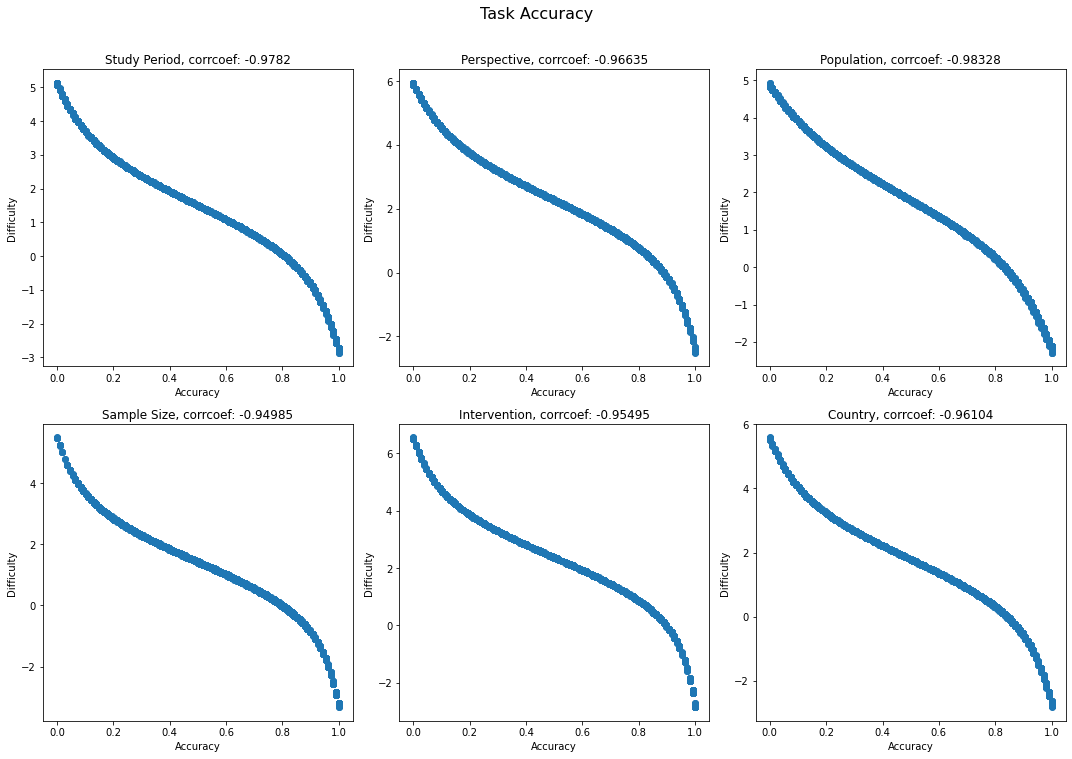

In [11]:
# overall
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
col_counter = 0
row_counter = 0
for i in range(6):
    cur_col = col_names[i]
    axes[col_counter][row_counter].scatter(all_classes_acc_result[cur_col]['acc'], all_classes_acc_result[cur_col]['diff'])
    cur_corr = np.corrcoef(all_classes_acc_result[cur_col]['diff'], all_classes_acc_result[cur_col]['acc'])[0][1]
    axes[col_counter][row_counter].title.set_text(cur_col + f', corrcoef: {round(cur_corr, 5)}')
    axes[col_counter][row_counter].set_xlabel('Accuracy')
    axes[col_counter][row_counter].set_ylabel('Difficulty')
    row_counter += 1
    if row_counter % 3 == 0:
        col_counter +=1
        row_counter = 0
fig.tight_layout()
fig.suptitle('Task Accuracy', size=16, y=1.05)
fig.savefig(os.path.join(cwd, 'saved_figures', 'task_diff_acc_corr.png'), bbox_inches='tight')
plt.show()

Accuracy Distribution

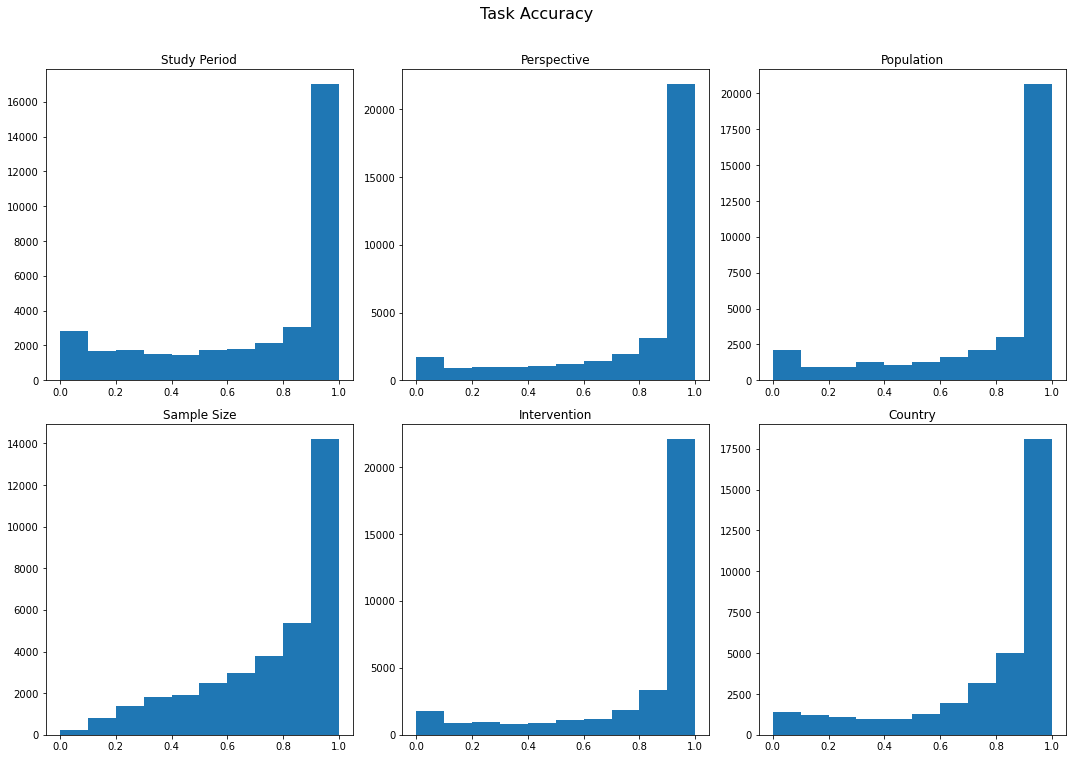

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
col_counter = 0
row_counter = 0
for i in range(6):
    cur_col = col_names[i]
    axes[col_counter][row_counter].hist(all_classes_acc_result[cur_col]['acc'])
    axes[col_counter][row_counter].title.set_text(cur_col)
    row_counter += 1
    if row_counter % 3 == 0:
        col_counter +=1
        row_counter = 0
fig.tight_layout()
fig.suptitle('Task Accuracy', size=16, y=1.05)
fig.savefig(os.path.join(cwd, 'saved_figures', 'task_acc_dist.png'), bbox_inches='tight')
plt.show()

## Crowd Accuracy v.s. Num Filters/Corruption Ratio

### Col Names

In [13]:
col_names = ['Study Period', 'Perspective', 'Population', 'Sample Size', 'Intervention', 'Country']

### Get Crowd Info Dfs & calculate the crowd acc

In [19]:
def calculate_crowd_acc_single(cur_model_judgement_path):
    # acc
    cur_df = pd.read_csv(cur_model_judgement_path)
    cur_acc = cur_df['Judgement'].mean()
    # crowd id
    cur_id = os.path.basename(cur_model_judgement_path).split('.')[0]
    cur_id = int(cur_id)

    return cur_id, cur_acc

def calculate_crowd_acc(cur_col_name):
    paths = glob.glob(os.path.join(cwd, 'train_only_data', 'model_judgement', cur_col_name, '*.csv'))
    # results = p_map(calculate_crowd_acc_single, paths, num_cpus=10)
    results = [calculate_crowd_acc_single(i) for i in paths]
    ids = []
    accs = []
    for cur_item in results:
        ids.append(cur_item[0])
        accs.append(cur_item[1])

    return pd.DataFrame({'CrowdID': ids, 'Acc': accs})


crowd_info_dfs = {}
for cur_col in col_names:
    print(f'{cur_col} Started')
    cur_path = glob.glob(os.path.join(cwd, 'crowd', cur_col, '*.csv'))[0]
    cur_df = pd.read_csv(cur_path, index_col=0)
    cur_acc_df = calculate_crowd_acc(cur_col)
    cur_result_df = pd.merge(cur_df, cur_acc_df, on='CrowdID')
    cur_result_df['CorruptionRatio'] =  cur_result_df['CorruptionRatio'].round(2)
    crowd_info_dfs[cur_col] = cur_result_df

Study Period Started
Perspective Started
Population Started
Sample Size Started
Intervention Started
Country Started


In [20]:
crowd_info_dfs['Country']

,CrowdID,NumFilters,Direction,CorruptionRatio,Acc
0,0,5,neg,0.05,0.841839
1,1,10,pos,0.05,0.794977
2,2,15,neg,0.05,0.836210
3,3,20,neg,0.05,0.816179
4,4,25,neg,0.05,0.834610
...,...,...,...,...,...
103,103,25,neg,0.60,0.792491
104,104,30,pos,0.60,0.721854
105,105,35,neg,0.60,0.765487
106,106,40,neg,0.60,0.763230


### Generate Heatmap

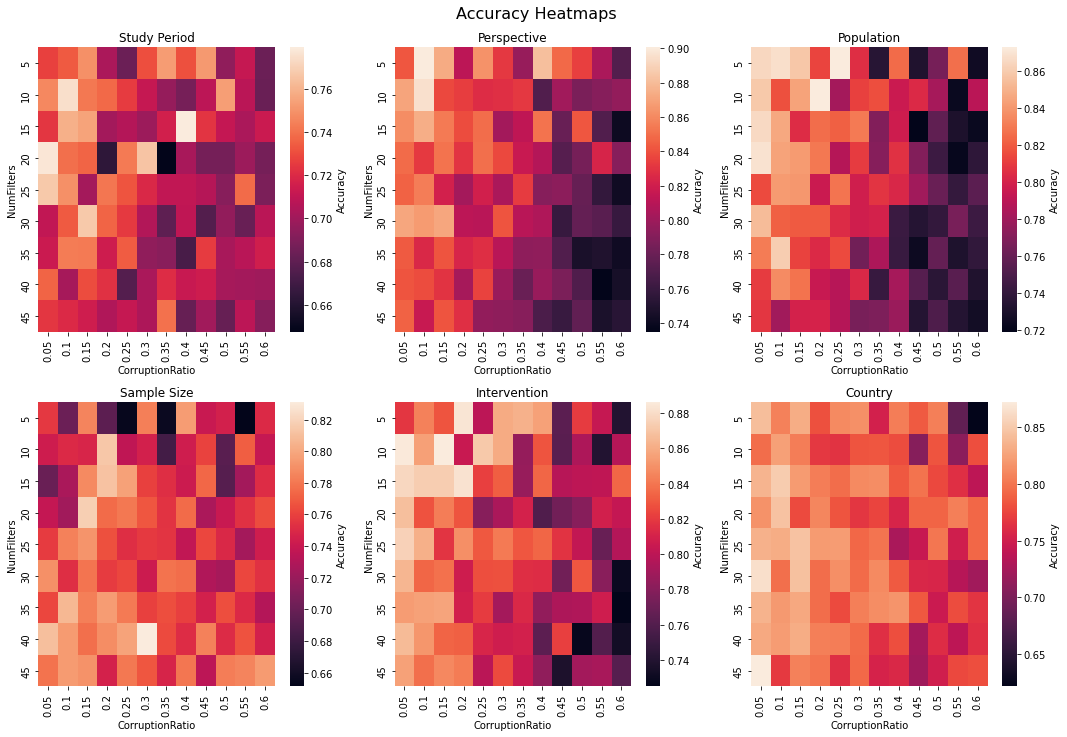

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
col_counter = 0
row_counter = 0
for i in range(6):
    cur_col = col_names[i]
    sns.heatmap(crowd_info_dfs[cur_col].pivot('NumFilters', 'CorruptionRatio', 'Acc'), ax=axes[col_counter][row_counter],  cbar_kws={'label': 'Accuracy'})
    axes[col_counter][row_counter].title.set_text(cur_col)
    row_counter += 1
    if row_counter % 3 == 0:
        col_counter +=1
        row_counter = 0
fig.tight_layout()
fig.suptitle('Accuracy Heatmaps', size=16, y=1.02)
fig.savefig(os.path.join(cwd, 'saved_figures', 'crowd_acc_heatmap.png'), bbox_inches='tight')
plt.show()